# Multivariate Time Series Analysis Lab

## Background

This lab will help you properly analyze a **stationary** time series dataset, which means in part that the data:

- Is **not** seasonal
 - lacks regular and predictable changes recurring every year
- Has **no** trend
 - lacks long term upward or downward movement

> **Note:** Time series with seasonality and trends require additional analysis even though the (S)ARIMA(X) method used here can handle them.

### What You'll DO

<span style='background :yellow' > Important, key lines of code will be missing portions marked by **T_O_D_O** for you to fill in.</span>

Review the lectures and package documentation (referenced throughout the lab) to apply what you learn and fill in these gaps. 

The primary lectures this lab builds upon:

- *Mining Data from Time Series*
- *Understanding and Applying Linear Regression*

### About the Dataset

The data spans from 1970 Q1 to 2019 Q2 and is an economic times series of quarterly percentage changes (growth rates) of five variables:

- personal **consumption** expenditure
- personal disposable **income**
- personal **savings**
- industrial **production**
- **unemployment**

Consumption, income, savings, and production are in real terms (i.e. inflation adjusted).

**Source:** United States Federal Reserve Bank of St Louis and the `fpp3` package in R. You can read more about this dataset and the analysis of it in R from the free and open source textbook: [Forecasting: Principles and Practice (3rd ed)](https://otexts.com/fpp3/regression-intro.html#example-us-consumption-expenditure) by Rob J Hyndman and George Athanasopoulos. This lab gives you the starter code and guidance to analyze the dataset in Python.

### Python Packages

Ensure the following packages are installed into a Python 3.8.5 environment:

| Package| Purpose |
| :-- | :-- |
| `pandas` | data wrangling and plotting |
| `seaborn` | plotting |
| `matplotlib` | tweaking seaborn and pandas plots |
| `pmdarima` | aide for model parameter selection |
| `statsmodels` | time series analysis tools |
| `numpy` | data manipulation |
| `scipy` | to visualize a normal distribution |
| `jupyter` | running this notebook |

#### Installation Steps

**Step 1**: Using `conda` create that environment using:
    
```
conda create -n tsa python=3.8.5 pandas seaborn matplotlib statsmodels numpy scipy jupyter
```

**Step 2**: Install `pmdarima` separately after activating the environment using `pip`:

```
conda activate tsa
pip install pmdarima
```

**Step 3**: Launch this notebook from within the directory that contains it:

```
jupyter notebook
```

## Data Wrangling

Load the datasets and configure the pandas dataframe to use a time [PeriodIndex](https://pandas.pydata.org/docs/reference/api/pandas.PeriodIndex.html). Use the [pd.period_range](https://pandas.pydata.org/docs/reference/api/pandas.period_range.html?highlight=period_range#pandas.period_range) function to do this and make sure it matches the values of the `Quarter` column.

In [2]:
import pandas as pd
df = pd.read_csv("us_consumption.csv", header = 0, index_col = 0)
df.index = pd.period_range('1970Q1', '6/4/2019', freq='Q')
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 198 entries, 1970Q1 to 2019Q2
Freq: Q-DEC
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Quarter       198 non-null    object 
 1   Consumption   198 non-null    float64
 2   Income        198 non-null    float64
 3   Production    198 non-null    float64
 4   Savings       198 non-null    float64
 5   Unemployment  198 non-null    float64
dtypes: float64(5), object(1)
memory usage: 10.8+ KB


Next, drop the Quarter column from the dataframe as we won't need it.

In [3]:
df.columns.to_list()

['Quarter', 'Consumption', 'Income', 'Production', 'Savings', 'Unemployment']

In [4]:
df.drop('Quarter', axis=1, inplace=True)
df

,Consumption,Income,Production,Savings,Unemployment
1970Q1,0.618566,1.044801,-2.452486,5.299014,0.9
1970Q2,0.451984,1.225647,-0.551459,7.789894,0.5
1970Q3,0.872872,1.585154,-0.358652,7.403984,0.5
1970Q4,-0.271848,-0.239545,-2.185691,1.169898,0.7
1971Q1,1.901345,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...,...
2018Q2,0.983112,0.661825,1.117424,-2.723974,0.0
2018Q3,0.853181,0.806271,1.256722,-0.085686,-0.3
2018Q4,0.356512,0.695142,0.948148,5.031337,0.2
2019Q1,0.282885,1.100753,-0.488206,9.760287,-0.1


## Exploratory Data Analysis (EDA)

Look at the time series data visualized as a line plot over time using `pandas`.

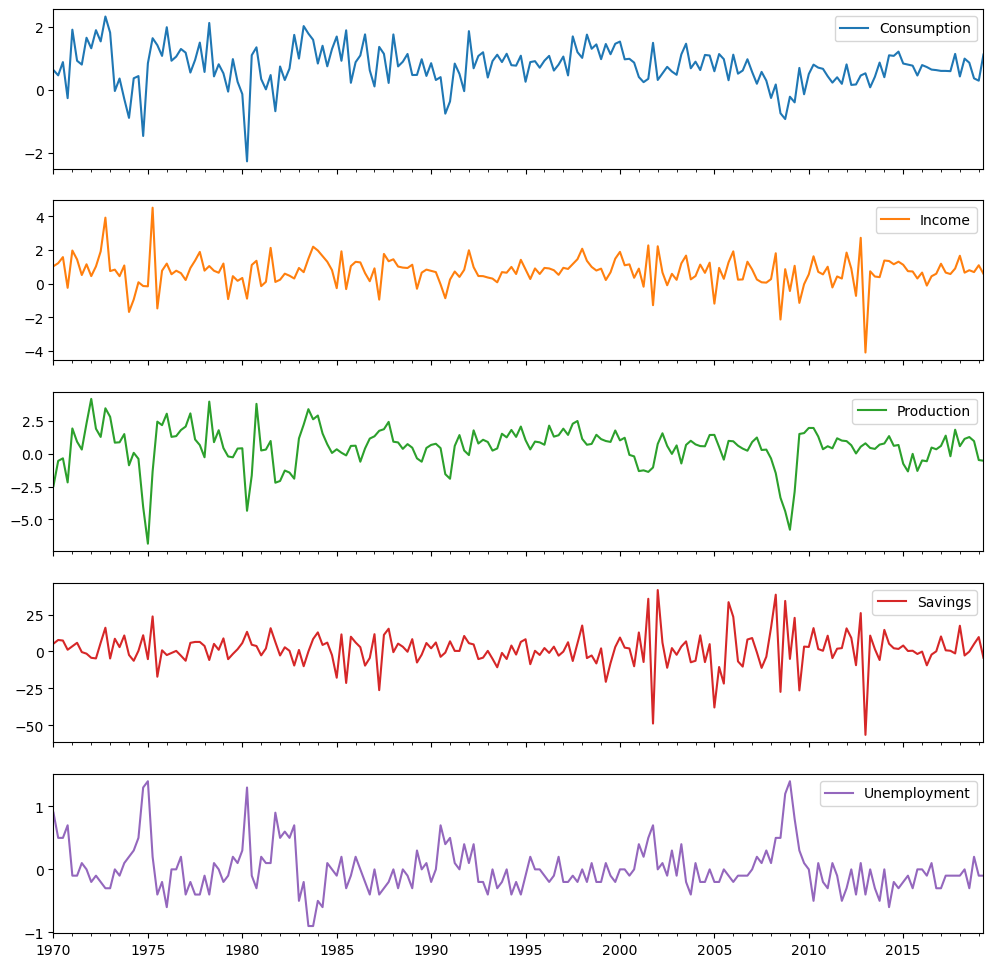

In [5]:
import matplotlib.pyplot as plt
df.plot.line(subplots=True, figsize=(12,12))
plt.show()

Visualize the data without the time component by seeing the [paired scatter plots](https://seaborn.pydata.org/generated/seaborn.pairplot.html) of the relationships between these five variables with `seaborn`.

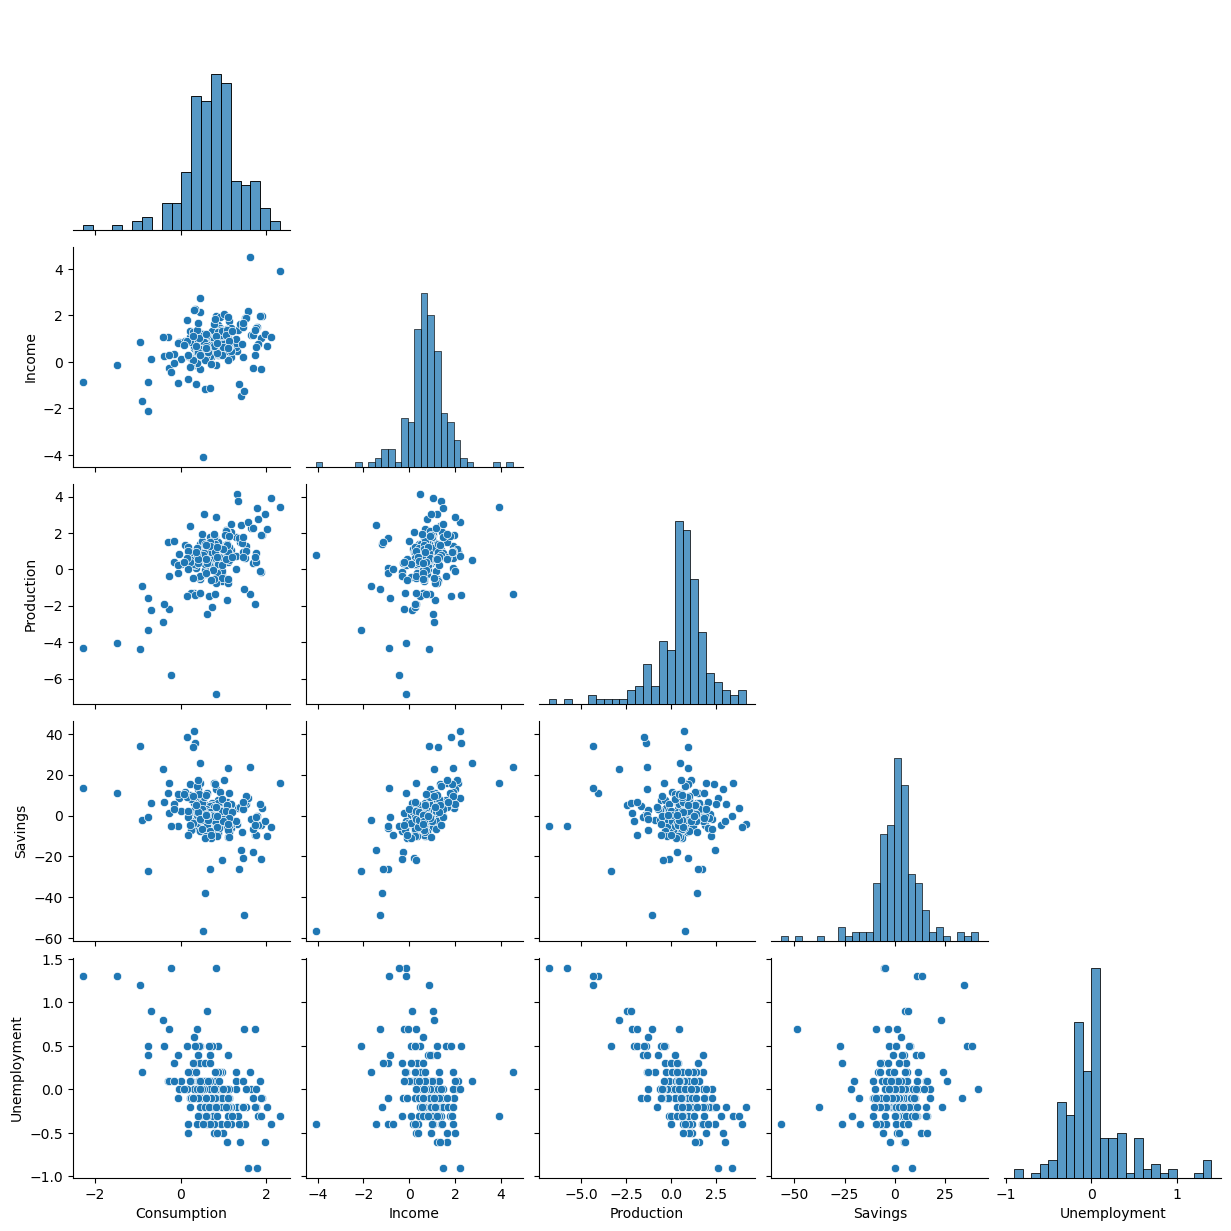

In [6]:
import seaborn as sns
sns.pairplot(df, corner=True)
plt.show()

### Think about the data

What relationships do you see between the variables in both plots above? Do you think a regression analysis will be useful on this data set? These questions can help inform on what kind of model would work best on this. This lab will use the AIRMA model introduced in the lectures. Other models could also work on this dataset, but those are outside the scope of this lab.

## Building an AIRMA model with exogenous variables

> **Note:** This kind of model is also known as a dynamic regression

### Preprocessing Data

Use `.iloc` to [slice out](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) the four predictor variables (income, production, savings, employment). You should see printed out a dataframe with the period index followed by columns of the these variables.

In [7]:
df.columns.to_list()

['Consumption', 'Income', 'Production', 'Savings', 'Unemployment']

In [8]:
predictors = df.iloc[0:198, 1:5]
predictors

,Income,Production,Savings,Unemployment
1970Q1,1.044801,-2.452486,5.299014,0.9
1970Q2,1.225647,-0.551459,7.789894,0.5
1970Q3,1.585154,-0.358652,7.403984,0.5
1970Q4,-0.239545,-2.185691,1.169898,0.7
1971Q1,1.975925,1.909764,3.535667,-0.1
...,...,...,...,...
2018Q2,0.661825,1.117424,-2.723974,0.0
2018Q3,0.806271,1.256722,-0.085686,-0.3
2018Q4,0.695142,0.948148,5.031337,0.2
2019Q1,1.100753,-0.488206,9.760287,-0.1


Use .iloc to splice out the response variable, *Consumption*. You should see printed out a dataframe with the period index followed by the response variable.

In [9]:
response = df.iloc[:, :1]
response

,Consumption
1970Q1,0.618566
1970Q2,0.451984
1970Q3,0.872872
1970Q4,-0.271848
1971Q1,1.901345
...,...
2018Q2,0.983112
2018Q3,0.853181
2018Q4,0.356512
2019Q1,0.282885


### Using an AutoML tool to find AIRMA parameters 

Here we'll use the `pmdarima` package to help us find the `p`, `d`, and `q` variables of the ARIMA model. 

We need `suppress_warngins=False` we want to ensure that there are no failed to converge warnings as the model won't be reliable if convergence isn't achieved. In order to do that, we'll need to set `maxitter` higher than the default of 50. Beware that higher values will take longer to run, so some patience will be needed.

When `maxiter` is set high enough you should not see any convergence warnings. 

> **Note:** Depending on the parameters used with `auto_arima` you might see other warnings like a deprecation and/or a non-invertible starting MA parameters found warning. You can ignore these.

In [10]:
import pmdarima as pm
auto = pm.auto_arima(y=response, exogenous=predictors, suppress_warnings=False, 
                     stationary=True, maxiter=20000)
auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -43.889
Date:                Tue, 20 Dec 2022   AIC                            103.777
Time:                        08:56:03   BIC                            130.083
Sample:                    03-31-1970   HQIC                           114.425
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.4197      0.078      5.382      0.000       0.267       0.572
Income           0.7611      0.031     24.904      0.000       0.701       0.821
Production       0.0487      0.024      2.055      0.040       0.002       0.095
Savings         -0.0542      0.002    -27.750      0.000      -0.058      -0.050
Unemployment    -0.1470      0.114     -1.289      0.198      -0.371       0.077
ar.L1           -0.7563      0.224     -3.372      0.001      -1.196      -0.317
ma.L1            0.6431      0.263      2.444      0.015       0.127       1.159
sigma2           0.0912      0.008     12.140      0.000       0.076       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                24.56
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.47
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Setting ARIMA parameters

Use the model above to set the `sm.tsa.SARIMAX(p, d, q)` paremeters below and fit the model to the data using the same `maxiter` value used above. 

The [SARIMAX documentation](https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) may prove helpful.

> **Note:** The output of this cell should match the previous (or be very close). If it doesn't check to see if there is an intercept term missing from the model above, but showing in the output below. If that's the case, remove `trend='c'` which specifies to add an intercept term.

In [11]:
import statsmodels.api as sm
model = sm.tsa.SARIMAX(endog=response, exog=predictors, trend='c', order=(1,0,1))
result = model.fit(maxiter=20000, disp=0)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -43.889
Date:                Tue, 20 Dec 2022   AIC                            103.777
Time:                        08:56:03   BIC                            130.083
Sample:                    03-31-1970   HQIC                           114.425
                         - 06-30-2019                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.4197      0.078      5.382      0.000       0.267       0.572
Income           0.7611      0.031     24.904      0.000       0.701       0.821
Production       0.0487      0.024      2.055      0.040       0.002       0.095
Savings         -0.0542      0.002    -27.750      0.000      -0.058      -0.050
Unemployment    -0.1470      0.114     -1.289      0.198      -0.371       0.077
ar.L1           -0.7563      0.224     -3.372      0.001      -1.196      -0.317
ma.L1            0.6431      0.263      2.444      0.015       0.127       1.159
sigma2           0.0912      0.008     12.140      0.000       0.076       0.106
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                24.56
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.56   Skew:                             0.47
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Model Diagnostics

Always check the assumptions of a statistical model. Failure to do so can lead to unreliable inferences, predictions, and forecasts. The more assumptions that are violated, the less usable the models are. In real world datasets, it's common for one or more assumptions to be violated. This isn't neccessarily a problem if the violation is minor. If it's major you'll likely need to look into statistical methods to remedy violations which we won't cover here.

### Assumption 1: No Residual Autocorrelations

Check the autocorrelations of the model residuals to ensure there all non-zerio lags don't fall grossly outside of the white noise zone (which would be the blue shading of the plot). You should see lag 7 slightly outside the range, but this shouldn't pose a big issue.

To do this you'll need to use the plot_acf function from `statsmodels`. Fill in the missing parts below to display 20 lags along the x-axis. You'll need to provide two parameters to the `plot_acf` method to do this.

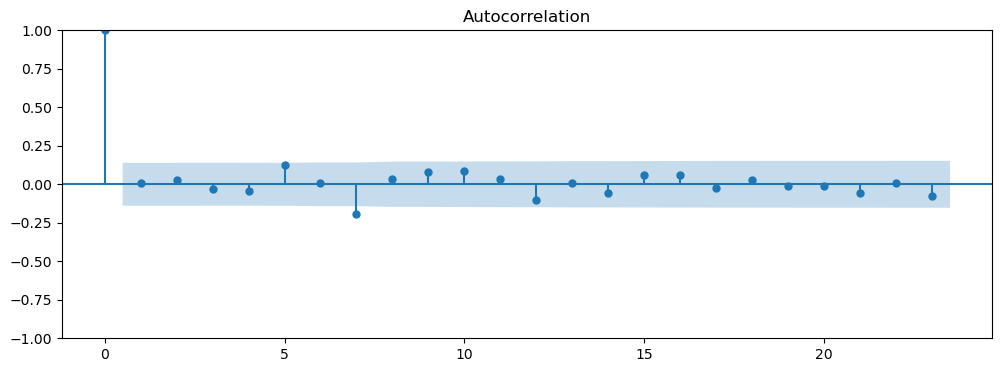

In [26]:
def autocorrelation_plot(data):
    from statsmodels.graphics.tsaplots import plot_acf
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.gca()    
    plot_acf(data.resid, ax=ax1)
    plt.show()
    
autocorrelation_plot(result)

### Assumption 2: No Excessive Residual Skew or Kurtosis

This function is directly from the *Mining Data from Time Series* lecture. What we want to see from it's output is a histogram that resembles:

- a normal distribution wouthout too much kurtosis (not too tall and skinny in the middle) 
- and isn't skewed to the left or right too much (peak should be centered with the superimposed normal distribution's peak)

If the historgram deviates too much from these ideals it may mean our model will not be reliable for forecasting.

How do you feel about the distribution visualized belwo for this model below?

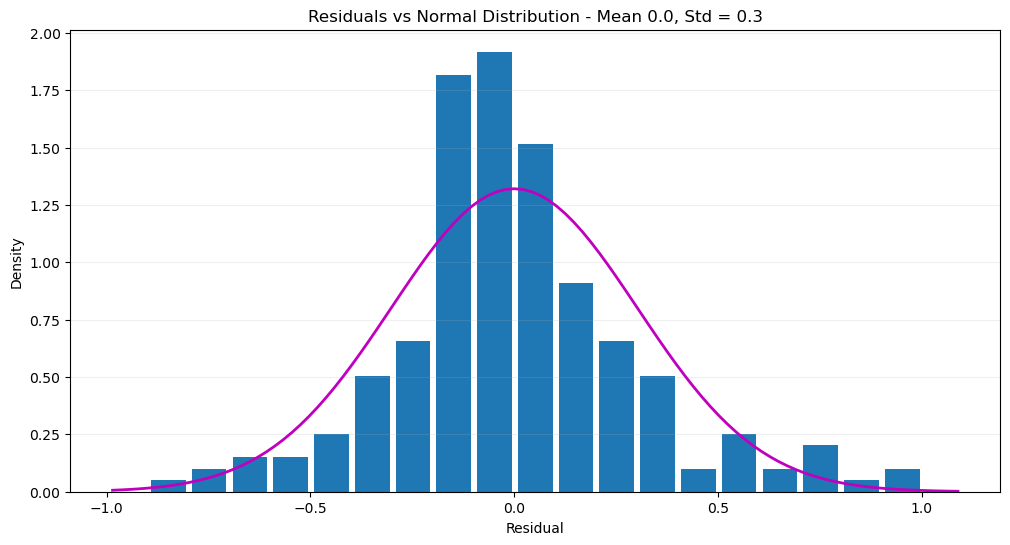

In [13]:
def resid_histogram(data):
    from numpy import linspace
    from scipy.stats import norm
    plt.figure(figsize=(12, 6))
    plt.hist(data, bins = 'auto', density = True, rwidth = 0.85, label ='Residuals')
    mean_resid, std_resid = norm.fit(data)
    xmin, xmax = plt.xlim()
    curve_length = linspace(xmin, xmax, 100)
    bell_curve = norm.pdf(curve_length, mean_resid, std_resid)
    plt.plot(curve_length, bell_curve, 'm', linewidth = 2)
    plt.grid(axis='y', alpha = 0.2)
    plt.xlabel('Residual')
    plt.ylabel('Density')
    plt.title(f'Residuals vs Normal Distribution - Mean {round(mean_resid, 1)}, Std = {round(std_resid, 1)}')
    plt.show()
    
resid_histogram(result.resid)

### Assumption 3: Residual Constant Variance

Regression models assume the model residuals have constant variance ([homoskedasticity](https://www.investopedia.com/terms/h/homoskedastic.asp#:~:text=What%20is%20Homoskedastic%3F,of%20the%20predictor%20variable%20changes)). Use pandas to perform a line plot of the residuals overtime by filling in the missing code below

Do you think these residuals have constant variance or are they subject to large changes?

> **Note:** These plots typically use standardized residuals to exaggerate the differences to make this more clear and we'll see an example of such a diagnostic plot later, but the purpose here is to help you understand what you are visualizing.

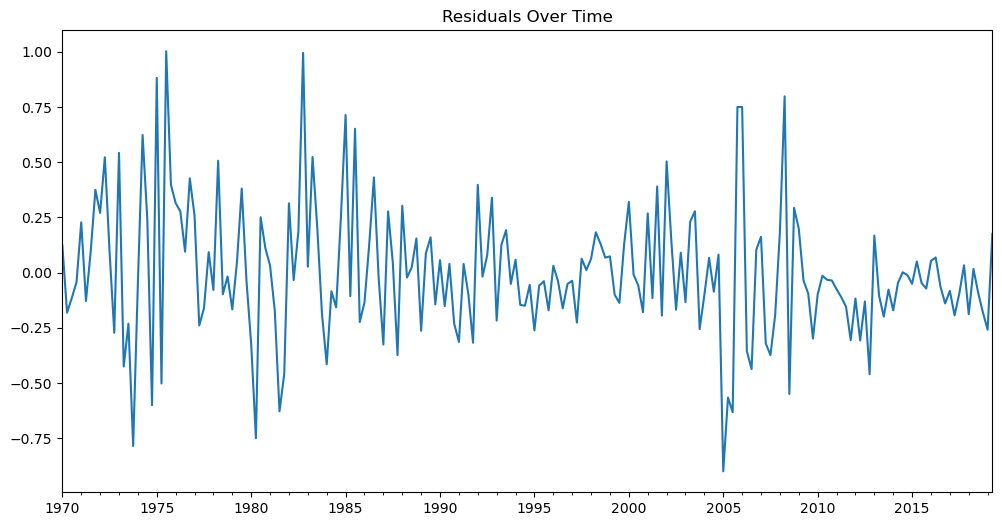

In [21]:
def residuals_over_time(data):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.gca()
    result.resid.plot()
    plt.title('Residuals Over Time')
    plt.show()
    
residuals_over_time(result)

### Assumption 4: Residuals vs Fitted Values Randomly Scattered

What we want to see here is no clear trend or pattern, no correlation between the x and y axis.

Create a scatterplot of the fitted values for the x-axis and the residual values for the y-axis.

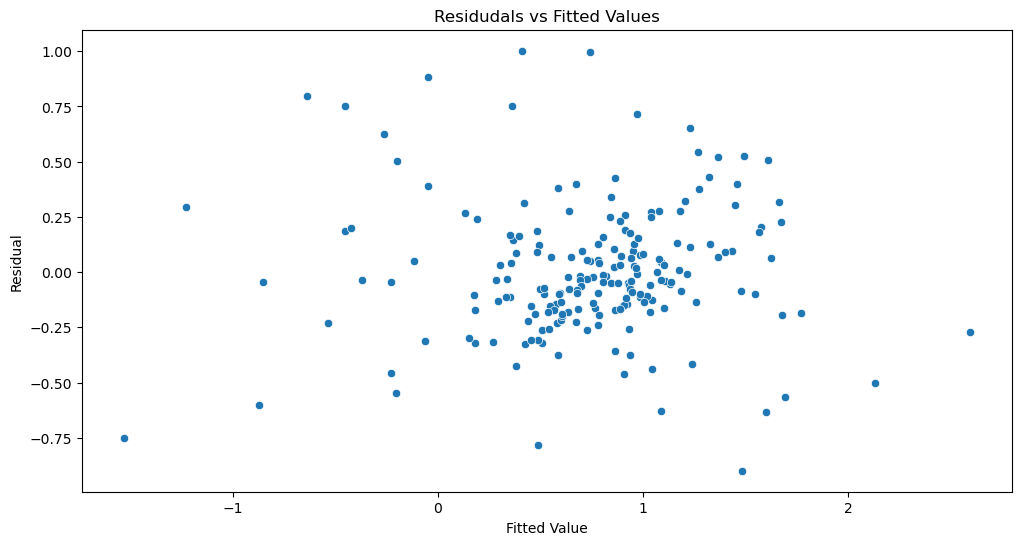

In [32]:
def residuals(data):
    fig = plt.figure(figsize=(12, 6))
    ax1 = fig.gca()
    sns.scatterplot(x=data.fittedvalues, y=data.resid, ax=ax1)
    plt.title('Residudals vs Fitted Values')
    plt.ylabel('Residual')
    plt.xlabel('Fitted Value')
    plt.show()
    
residuals(result)

## Diagnostics Convience Function

`Statsmodels` comes with one-liner `plot_diagnositics` funtion that gives us 3 of the 4 above plots with some modifications:

- Residuals over time are standardized making the variation easy to notice
- Historgram includes a kernal denesity estimation (`KDE`) curve to help visualize how closly the histogram resembles the normal distribution (`N(0,1)`)
- Correlogram is another name for ACF

Additionally, it also shows a Q-Q plot, which is another common way to check if the residuals or normally distributed. The dots should line up mostly along the diagonal line. The further they deviate from that line the more the normality assumption is violated.

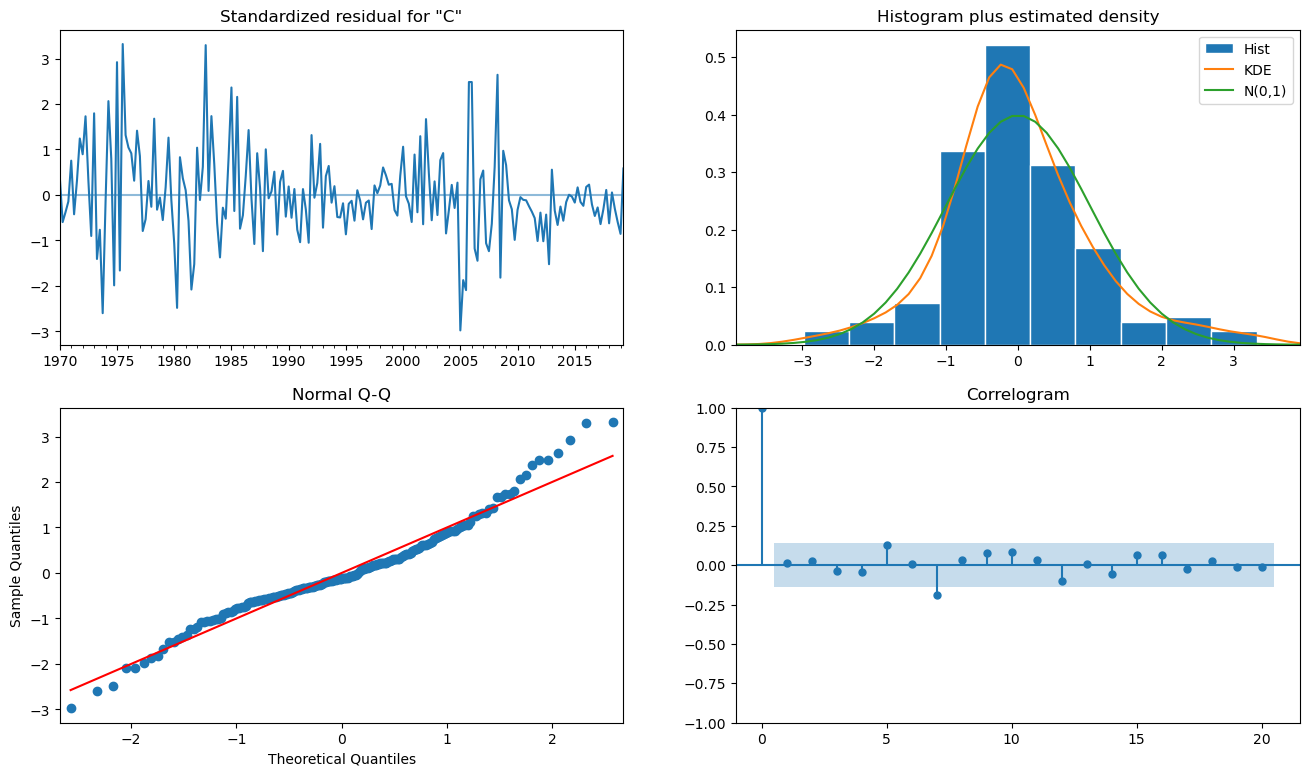

In [33]:
fig = plt.figure(figsize=(16, 9))
result.plot_diagnostics(fig=fig, lags=20)
plt.show()

## Scenerio Forecasting

Lastly, we'll use this model to forcast changes in US consumption over the next year, with the scenerio of unemployment growth rates increase linearly from 0.1% to 1%. You'll see below all other predictor variables are held constant with only the unemployment variable changing. This gives us some idea of the impact unemployement rates have on personal consumption rates in the US.

> **NOTE:** When forecasting scenerios like this, beware of the risk of extrapolating the forecasts beyond what the model can handle. In this case, check the first EDA plot above and you'll see the unemployment percent changes have stayed mostly between -1% and +1%. Thus ensure forecasts use scenerios that use values between these ranges, not outside of them. Doing the latter will lead to unreliable forecasts.

In [34]:
current=predictors.iloc[-1,:]
scenerio=[]
num_quarters = 4
for i in range(num_quarters):
    current = current.copy()
    new_unemployment_rate = 1.0
    current.Unemployment += (new_unemployment_rate - current.Unemployment) / (num_quarters-1) * i
    scenerio.append(current)
scenerio

[Income          0.593399
 Production     -0.539949
 Savings        -4.264616
 Unemployment   -0.100000
 Name: 2019Q2, dtype: float64,
 Income          0.593399
 Production     -0.539949
 Savings        -4.264616
 Unemployment    0.266667
 Name: 2019Q2, dtype: float64,
 Income          0.593399
 Production     -0.539949
 Savings        -4.264616
 Unemployment    0.755556
 Name: 2019Q2, dtype: float64,
 Income          0.593399
 Production     -0.539949
 Savings        -4.264616
 Unemployment    1.000000
 Name: 2019Q2, dtype: float64]

To visualize the effect of the unemployment rate changing use the [`get_forecast`](https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_forecasting.html) method of the `statsmodels` object. Fill in the missing code to forecast 4 quarters into the future using the scenerio defined above. 

The forecast below shows:

- the historical time series of consumption in blue,
- a point forecast (black line showing the most likely result), and 
- a 95% prediction interval (in grey shading showing that we are 95% confident that other possible outcomes will not exceed the shaded area)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

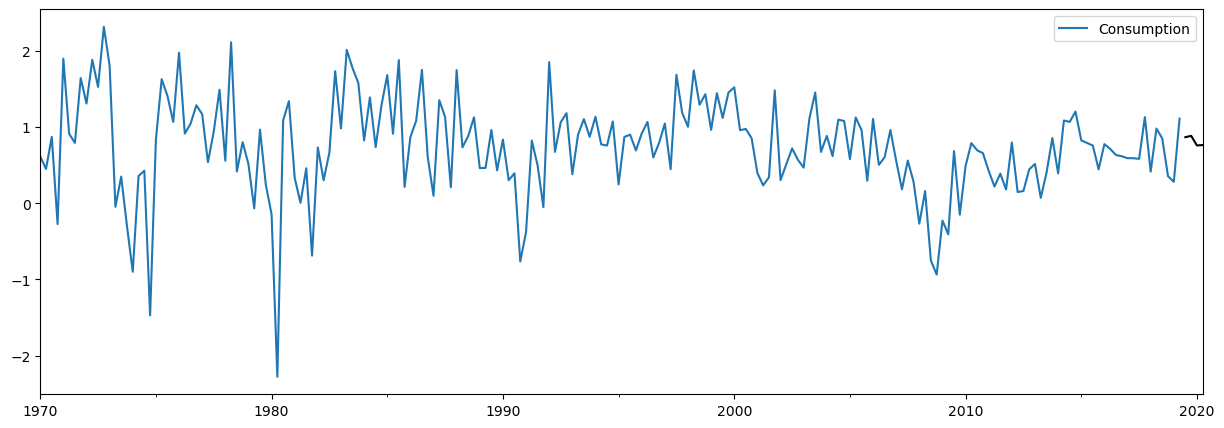

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
response.plot(ax=ax)
fcast = result.get_forecast(4, exog=scenerio).summary_frame()
fcast['mean'].plot(ax=ax, style='k-')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1)
plt.show()

Given what you can observe about the data in the EDA section and what you know about the economy in general, does this forcast seem reasonable? 

## Parting Ideas

Feel free to play around with some other scenerios and see how they affect the forecast. 

Or try to tweak the ARIMA parameters (e.g. `p, q, d = 4, 5, 4`) to see how it affects the diagnostic plots and forecasts.

This ends the lab.